# 6. Plot All Results

gg-napari-env

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import regionprops
from scipy import stats
from napari_czifile2 import napari_get_reader
from skimage import io
import os 
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
# Get directories that contains 488, 546 or 647 
raw_data_dirs = [x for x in raw_data_dirs if 'P14' in x]
raw_data_dirs

['20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI',
 '20250523 C P14 T U54-647 Lnc4-546 DAPI',
 '20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI',
 '20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI',
 '20250701 F P14 U34-b3-546 Orco-b4-647 DAPI',
 '20250523 B P14 T 9E88-546 Lnc-647 DAPI']

In [3]:
coexpression_nuc_norm_threshold = 0.1 # was 0.1 
cyto_norm_threshold = 0.2 # was 0.2  

In [4]:
final_results_each_image = [] 
final_results = [] 

In [5]:
def plot_nuc_cyto_props(input, results_melted, chosen_channel, channels_to_plot, plot_colors, figwidth=1.75, figheight=1.75, offset=0.25): 

    # Filter results for the chosen channel
    results_subset = results_melted[(results_melted["chosen_OR_name"] == chosen_channel) & (results_melted["channel_name"].isin(channels_to_plot))]

    # Calculate nuclear proportions
    results_thresholded_nuc = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
    results_thresholded_nuc['total_cells'] = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel'])['nuc-norm'].count().values
    results_thresholded_nuc['prop-nuclear'] = results_thresholded_nuc['nuclear'] / results_thresholded_nuc['total_cells']

    # Calculate cytoplasmic proportions
    results_thresholded_cyto = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
    results_thresholded_cyto['total_cells'] = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel'])['cyto-norm'].count().values
    results_thresholded_cyto['prop-cytoplasmic'] = results_thresholded_cyto['cytoplasmic'] / results_thresholded_cyto['total_cells']

    # Merge both
    results_thresholded = pd.merge(results_thresholded_nuc, results_thresholded_cyto, on=['image', 'chosen_OR_name', 'channel_name', 'channel', 'total_cells'])
    final_results_each_image.append(results_thresholded)

    # Get means for final-results
    final_results_across_images = results_thresholded.groupby(['chosen_OR_name', 'channel_name']).agg({'image': 'nunique', 'channel': 'first', 'total_cells': 'mean', 'nuclear': 'mean', 'cytoplasmic': 'mean', 'prop-nuclear': 'mean', 'prop-cytoplasmic': 'mean'}).reset_index()
    final_results.append(final_results_across_images)

    # Map channels to x positions
    channel_to_x = {ch: i for i, ch in enumerate(channels_to_plot)}
    results_thresholded['x_nuclear'] = results_thresholded['channel_name'].map(lambda x: channel_to_x[x] - offset)
    results_thresholded['x_cyto'] = results_thresholded['channel_name'].map(lambda x: channel_to_x[x] + offset)

    # Start plotting
    f, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), dpi=300)

    for ch_name, color in zip(channels_to_plot, plot_colors):
        df_sub = results_thresholded[results_thresholded['channel_name'] == ch_name]

        # Plot swarmplots for nuclear and cytoplasmic proportions, with offsets and jitter and different markers
        sns.swarmplot(data=df_sub, x='x_nuclear', y='prop-nuclear', ax=ax, alpha=1, s=3, color=color, marker='o', zorder=1, dodge=True) 
        sns.swarmplot(data=df_sub, x='x_cyto', y='prop-cytoplasmic', ax=ax, alpha=1, s=3, facecolors='none', edgecolor=color, linewidth=0.8, marker='o', zorder=1, dodge=True)

        # Plot 95% CI using sns barplot 
        sns.barplot(data=df_sub, x='x_nuclear', y='prop-nuclear', ax=ax, color=color, alpha=0, capsize=0.2, errwidth=1, errcolor='black', zorder=1, errorbar=("ci", 95)) 
        sns.barplot(data=df_sub, x='x_cyto', y='prop-cytoplasmic', ax=ax, color=color, alpha=0, capsize=0.2, errwidth=1, errcolor='black', zorder=1, errorbar=("ci", 95))

    # Add text above each bar with "C" or "N"
    for x_nuc in results_thresholded['x_nuclear'].unique():
        ax.text(x_nuc*2+0.5, 1.1, 'Nuc', ha='center', va='bottom', fontsize=6, color='black')
    for x_cyto in results_thresholded['x_cyto'].unique():
        ax.text(x_cyto*2+0.5, 1.1, 'Cyt', ha='center', va='bottom', fontsize=6, color='black')


    # Formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticks([2*x+0.5 for x in list(channel_to_x.values())])
    ax.set_xticklabels(list(channel_to_x.keys()), fontsize=6)
    ax.set_xlabel(f"{chosen_channel}", fontsize=6)
    ax.set_ylabel("Proportion of OSNs", fontsize=6)

    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])


    # Tight layout and save
    plt.tight_layout()
    chosen_channel = chosen_channel.replace("/","-")
    plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{chosen_channel}-nuclear-and-cyto-proportion.pdf",
                format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

    plt.show() 

In [6]:
def plot_nuc_props(input, results_melted, chosen_channel, channels_to_plot, plot_colors, figwidth=1.5, figheight=1.5): 

    # Filter results for the chosen channel
    results_subset = results_melted[(results_melted["chosen_OR_name"] == chosen_channel) & (results_melted["channel_name"].isin(channels_to_plot))]

    # Calculate nuclear proportions
    results_thresholded_nuc = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
    results_thresholded_nuc['total_cells'] = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel'])['nuc-norm'].count().values
    results_thresholded_nuc['prop-nuclear'] = results_thresholded_nuc['nuclear'] / results_thresholded_nuc['total_cells']

    # Calculate cytoplasmic proportions
    results_thresholded_cyto = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
    results_thresholded_cyto['total_cells'] = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel'])['cyto-norm'].count().values
    results_thresholded_cyto['prop-cytoplasmic'] = results_thresholded_cyto['cytoplasmic'] / results_thresholded_cyto['total_cells']

    # Merge both
    results_thresholded = pd.merge(results_thresholded_nuc, results_thresholded_cyto, on=['image', 'chosen_OR_name', 'channel_name', 'channel', 'total_cells'])
    final_results_each_image.append(results_thresholded)

    # Get means for final-results
    final_results_across_images = results_thresholded.groupby(['chosen_OR_name', 'channel_name']).agg({'image': 'nunique', 'channel': 'first', 'total_cells': 'mean', 'nuclear': 'mean', 'cytoplasmic': 'mean', 'prop-nuclear': 'mean', 'prop-cytoplasmic': 'mean'}).reset_index()
    final_results.append(final_results_across_images)

    # Start plotting
    f, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), dpi=300)

    for i, ch_name, color in zip(range(len(channels_to_plot)), channels_to_plot, plot_colors):
        df_sub = results_thresholded_nuc[results_thresholded_nuc['channel_name'] == ch_name]

        # Plot swarmplots for nuclear and cytoplasmic proportions, with offsets and jitter and different markers
        sns.swarmplot(data=df_sub, x=i, y='prop-nuclear', ax=ax, alpha=1, s=3, color=color, marker='o', zorder=1, dodge=True)

        # Plot 95% CI using sns barplot
        sns.barplot(data=df_sub, x=i, y='prop-nuclear', ax=ax, color=color, alpha=0, capsize=0.2, errwidth=1, errcolor='black', zorder=1, errorbar=("ci", 95))

    # Formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticks(range(len(channels_to_plot)))
    ax.set_xticklabels(channels_to_plot, fontsize=6)
    ax.set_xlabel(f"{chosen_channel}", fontsize=6)
    ax.set_ylabel("Proportion of OSNs", fontsize=6)

    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

    # Tight layout and save
    plt.tight_layout()
    chosen_channel = chosen_channel.replace("/","-")
    plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{chosen_channel}-nuclear-and-cyto-proportion.pdf",
                format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

    plt.show() 

In [7]:
def plot_nuc_cyto_ratios(input, results_melted, chosen_channel, channels_to_plot, plot_colors, figwidth=1.75, figheight=1.75, offset=0.25): 

    # Filter results for the chosen channel
    results_subset = results_melted[(results_melted["chosen_OR_name"] == chosen_channel) & (results_melted["channel_name"].isin(channels_to_plot))]

    # Calculate nuclear proportions
    results_thresholded_nuc = results_subset.groupby(['image', 'chosen_OR_name', 'channel_name', 'channel']).apply(lambda x: (x['cyto-norm'] / x['nuc-norm']).mean()).reset_index(name='ratio')
    
    # Start plotting
    f, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), dpi=300)

    for i, ch_name, color in zip(range(len(channels_to_plot)), channels_to_plot, plot_colors):
        df_sub = results_thresholded_nuc[results_thresholded_nuc['channel_name'] == ch_name]

        # Plot swarmplots for nuclear and cytoplasmic proportions, with offsets and jitter and different markers
        sns.swarmplot(data=df_sub, x=i, y='ratio', ax=ax, alpha=1, s=3, color=color, marker='o', zorder=1, dodge=True)

        # Plot 95% CI using sns barplot
        sns.barplot(data=df_sub, x=i, y='ratio', ax=ax, color=color, alpha=0, capsize=0.2, errwidth=1, errcolor='black', zorder=1, errorbar=("ci", 95))

        # Print avg
        print(f"Average ratio for {ch_name}: {df_sub['ratio'].mean():.2f}")

    # Formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticks(range(len(channels_to_plot)))
    ax.set_xticklabels(channels_to_plot, fontsize=6)
    ax.set_xlabel(f"{chosen_channel}", fontsize=6)
    ax.set_ylabel("Nuclear / Cytoplasmic", fontsize=6)

    # Tight layout and save
    plt.tight_layout()
    chosen_channel = chosen_channel.replace("/","-")
    #plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{chosen_channel}-nuclear-and-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

    plt.show() 

# FIGURE 1

## Chymotrypsin & U34

In [8]:
input = 'U34'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory


In [9]:
channels = ['AF546', 'AF647']
channel_names = ["U34", "Chymotrypsin"]
channel_colors = ["cyan", "yellow"]
channel_maxs = [255, 255]

Average ratio for U34: 0.61
Average ratio for Chymotrypsin: 0.25


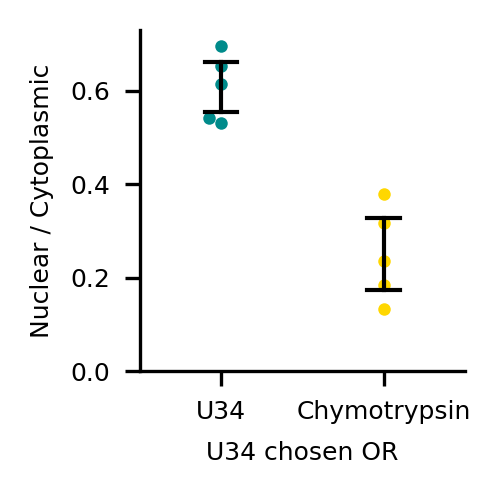

In [10]:
plot_nuc_cyto_ratios(input, results_melted, "U34 chosen OR", ["U34", "Chymotrypsin"], ["darkcyan", "gold"], figwidth=1.75, figheight=1.75)

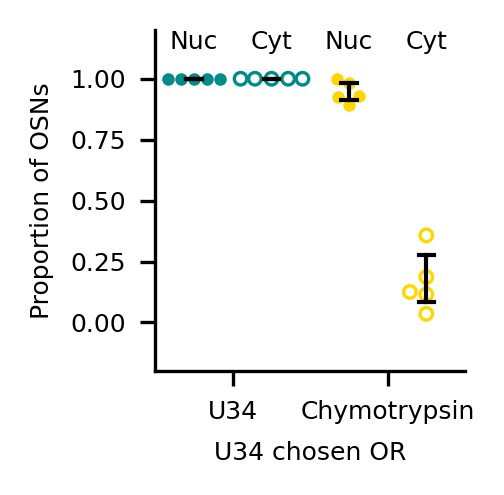

In [11]:
plot_nuc_cyto_props(input, results_melted, "U34 chosen OR", ["U34", "Chymotrypsin"], ["darkcyan", "gold"], figwidth=1.75, figheight=1.75)

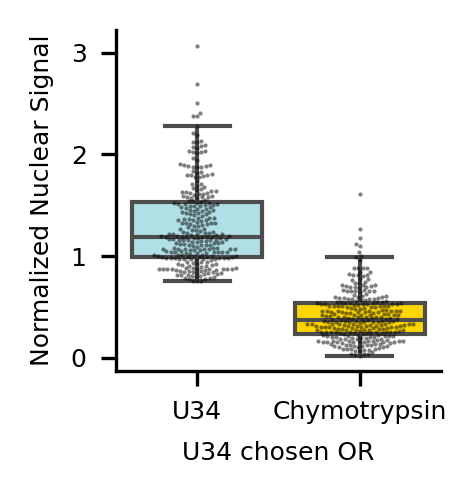

In [12]:
chosen_channel = "U34 chosen OR"
channels_to_plot = ["U34", "Chymotrypsin"]
plot_colors = ['powderblue', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["chosen_OR_name"] == chosen_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{chosen_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{chosen_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

# Perform nonparametric test for differences between samples 

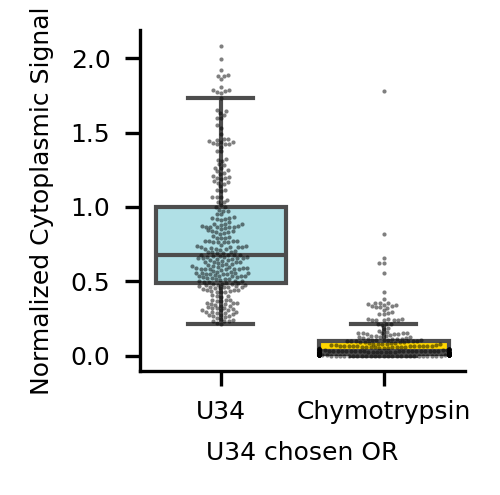

In [13]:
chosen_channel = "U34 chosen OR"
channels_to_plot = ["U34", "Chymotrypsin"]
plot_colors = ['powderblue', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["chosen_OR_name"] == chosen_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{chosen_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{chosen_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

## Orco & U34

In [14]:
input = 'Orco'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

# Create figure directory if it doesn't exist 
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250701 F P14 U34-b3-546 Orco-b4-647 DAPI as input directory


In [15]:
channels = ['AF546', 'AF647']
channel_names = ["U34", "Orco"]
channel_colors = ["cyan", "magenta"]
channel_maxs = [255, 255]

Average ratio for U34: 0.67
Average ratio for Orco: 1.52


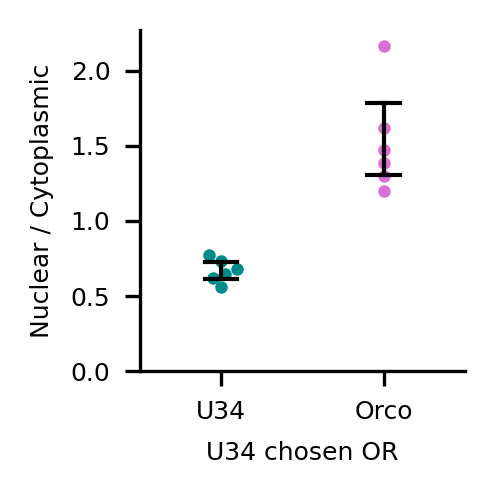

In [16]:
plot_nuc_cyto_ratios(input, results_melted, "U34 chosen OR", ["U34", "Orco"], ["darkcyan", "orchid"], figwidth=1.75, figheight=1.75)

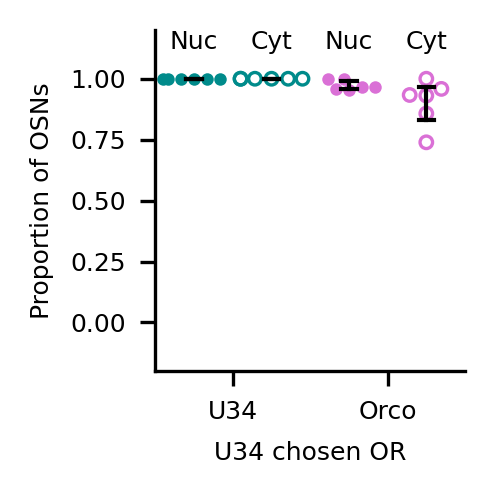

In [17]:
plot_nuc_cyto_props(input, results_melted, "U34 chosen OR", ["U34", "Orco"], ["darkcyan", "orchid"], figwidth=1.75, figheight=1.75)

# Supplementary 1 

## LOC105282603 & 9E108

In [18]:
input = 'LOC603'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI as input directory


In [19]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["LOC105282603", "9E108", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

Average ratio for 9E116: 0.73
Average ratio for LOC105282603: 0.44


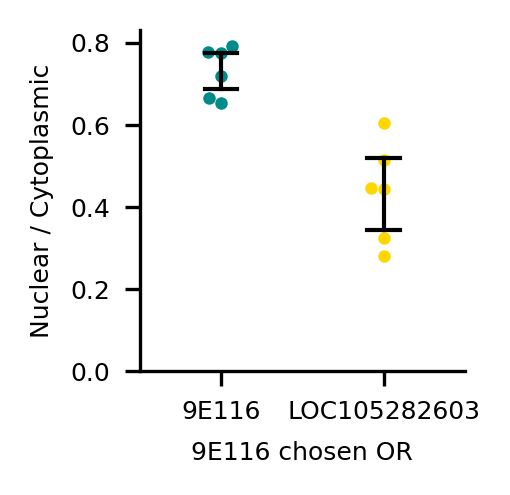

In [20]:
plot_nuc_cyto_ratios(input, results_melted, "9E116 chosen OR", ["9E116", "LOC105282603"], ['darkcyan', 'gold'], figwidth=1.75, figheight=1.75)

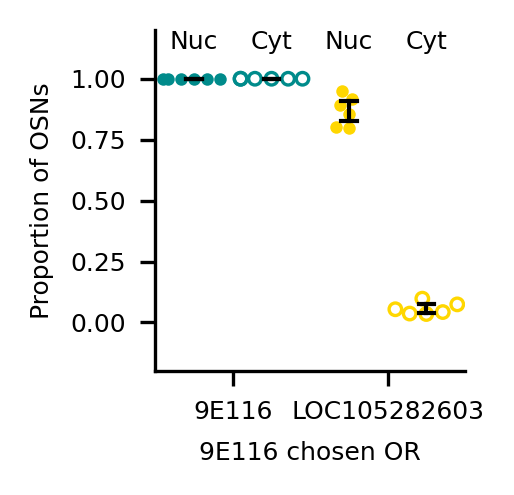

In [21]:
plot_nuc_cyto_props(input, results_melted, "9E116 chosen OR", ["9E116", "LOC105282603"], ['darkcyan', 'gold'], figwidth=1.75, figheight=1.75)

## 9E99 & LOC105286072

In [22]:
input = 'LOC105286072'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI as input directory


In [23]:
channels = ['AF594', 'AF647']
channel_names = ["9E99", "LOC105286072"]
channel_colors = ["cyan", "yellow"]
channel_maxs = [255, 255]

Average ratio for 9E99: 0.54
Average ratio for LOC105286072: 0.47


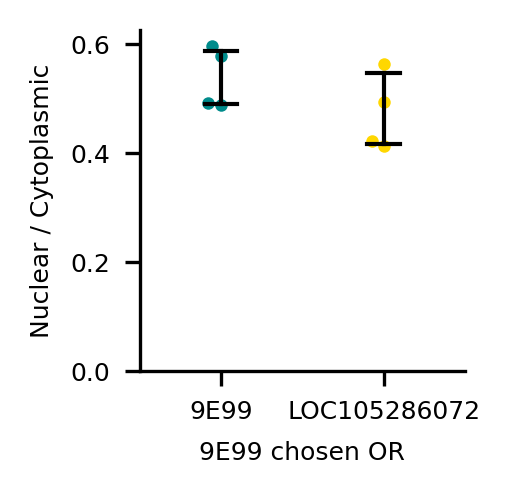

In [24]:
plot_nuc_cyto_ratios(input, results_melted, "9E99 chosen OR", ["9E99", "LOC105286072"], ['darkcyan', 'gold'], figwidth=1.75, figheight=1.75)

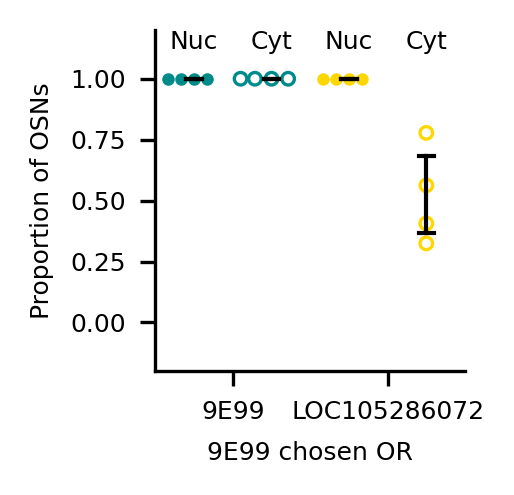

In [25]:
plot_nuc_cyto_props(input, results_melted, "9E99 chosen OR", ["9E99", "LOC105286072"], ['darkcyan', 'gold'], figwidth=1.75, figheight=1.75)

# FIGURE 2

## 9E213 & 9E214 & Intergenic

In [26]:
input = '20250523 A'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI as input directory


In [27]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E214", "9E213", "IPR"]
channel_colors = ["yellow", "cyan", "magenta"]
channel_maxs = [255, 255, 255]

Paired t-test between 9E214 nuclear proportion and 9E214 intergenic proportion overlap: t-statistic = -1.103761227191911, p-value = 0.31198558743850074


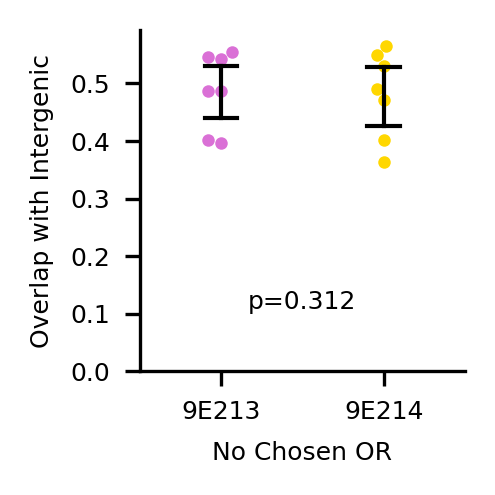

In [28]:
results['9E213-prop-overlap-intergenic'] = results['AF546-AF647-overlap-nucleus'] / results['AF647-area-nucleus']
results['9E214-prop-overlap-intergenic'] = results['AF488-AF647-overlap-nucleus'] / results['AF647-area-nucleus']

# Get results for where no channel is "cytoplasmic" 
results_subset = results[(~results['AF488-cytoplasmic']) & (~results['AF546-cytoplasmic']) & (~results['AF647-cytoplasmic']) &  (results['AF647-nuc-norm'] > 0.2)].groupby('image').mean().reset_index()
#results_subset = results[results['AF546-cytoplasmic']].groupby('image').mean().reset_index()

# Plot 9E214-nuc-prop and 9E214-intergenic-prop-overlap
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300)
sns.swarmplot(data=results_subset, x=0, y='9E213-prop-overlap-intergenic', ax=ax, color='orchid', alpha=1, s=3, legend=False, dodge=True, zorder=0)
sns.swarmplot(data=results_subset, x=1, y='9E214-prop-overlap-intergenic', ax=ax, color='gold', alpha=1, s=3, legend=False, dodge=True, zorder=0)

# Add statistical test (paired t-test) 
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(results_subset['9E214-prop-overlap-intergenic'], results_subset['9E213-prop-overlap-intergenic'])
print(f"Paired t-test between 9E214 nuclear proportion and 9E214 intergenic proportion overlap: t-statistic = {t_stat}, p-value = {p_value}")

# Add 95% confidence interval error bars using a transparent bar plot
sns.barplot(data=results_subset, x=0, y='9E213-prop-overlap-intergenic', ax=ax, alpha=0, capsize=0.2, errcolor='black', lw=0, errwidth=1, zorder=1)
sns.barplot(data=results_subset, x=1, y='9E214-prop-overlap-intergenic', ax=ax, alpha=0, capsize=0.2, errcolor='black', lw=0, errwidth=1, zorder=1)

# Add p-value to the plot 
ax.text(0.5, 0.1, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=6, color='black')

# Label axes 
ax.set_xlabel("No Chosen OR", fontsize=6)
ax.set_ylabel("Overlap with Intergenic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['9E213', '9E214'], fontsize=6)
ax.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-9E214-intergenic-nuc-prop.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show() 

Average ratio for 9E213: 0.74
Average ratio for IPR: 0.25
Average ratio for 9E214: 0.32


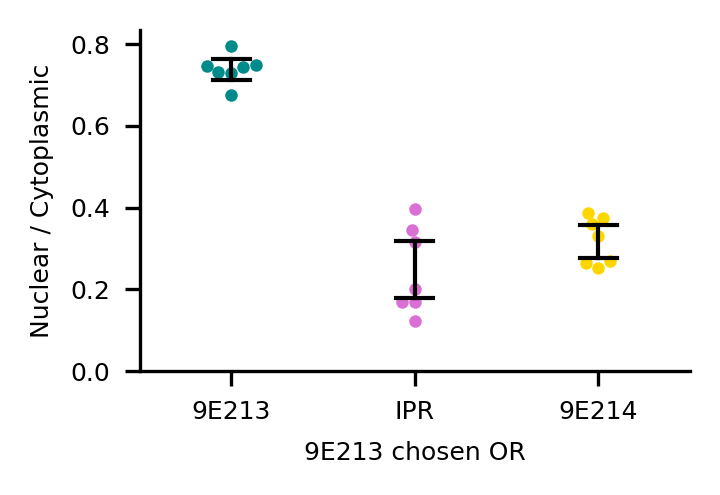

In [29]:
plot_nuc_cyto_ratios(input, results_melted, "9E213 chosen OR", ["9E213", "IPR", "9E214"], ['darkcyan', 'orchid', 'gold'], figwidth=2.5, figheight=1.75)

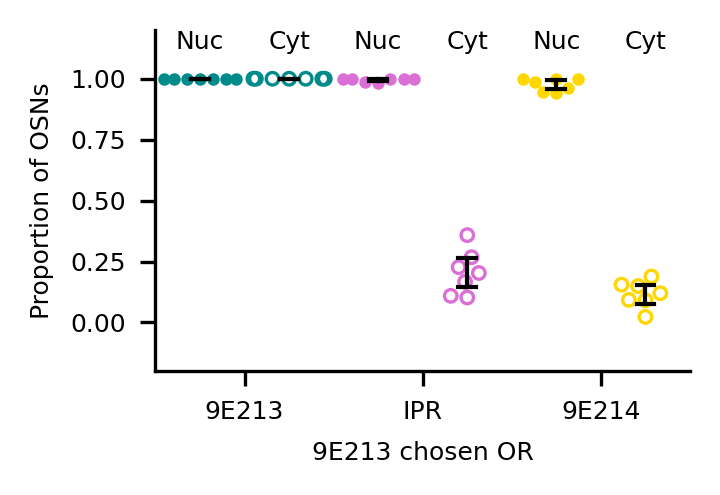

In [30]:
plot_nuc_cyto_props(input, results_melted, "9E213 chosen OR", ["9E213", "IPR", "9E214"], ['darkcyan', 'orchid', 'gold'], figwidth=2.5, figheight=1.75)

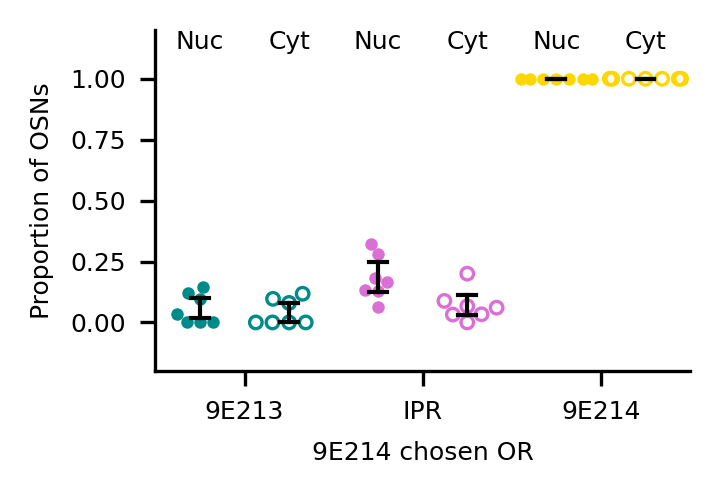

In [31]:
plot_nuc_cyto_props(input, results_melted, "9E214 chosen OR", ["9E213", "IPR", "9E214"], ['darkcyan', 'orchid', 'gold'], figwidth=2.5, figheight=1.75)

## 9E129 & 9E118-exons & 9E118-introns

In [32]:
input = '9E118'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI as input directory


In [33]:
"""# Drop rows where multiple channels are marked as cytoplasmic
results['cytoplasmic-count'] = 0 
for channel in channels:
    results['cytoplasmic-count'] += results[f'{channel}-cytoplasmic'].astype(int)

# Keep only rows where exactly one channel is marked as cytoplasmic 
# This helps remove some autofluorescence artifacts (cuticle mostly) that shows up in both channels 
results = results[results['cytoplasmic-count'] <= 1].reset_index(drop=True)"""

"# Drop rows where multiple channels are marked as cytoplasmic\nresults['cytoplasmic-count'] = 0 \nfor channel in channels:\n    results['cytoplasmic-count'] += results[f'{channel}-cytoplasmic'].astype(int)\n\n# Keep only rows where exactly one channel is marked as cytoplasmic \n# This helps remove some autofluorescence artifacts (cuticle mostly) that shows up in both channels \nresults = results[results['cytoplasmic-count'] <= 1].reset_index(drop=True)"

Paired t-test between 9E118 exons nuclear proportion and 9E118 exons proportion overlap with intron: t-statistic = 7.701686835797494, p-value = 0.0015293517593190132


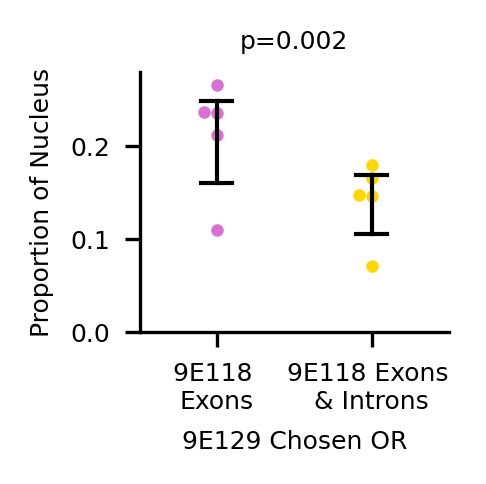

In [34]:
results['9E118-exons-nuc-prop'] = results['AF546-area-nucleus'] / results['nucleus_area']
results['9E118-exons-prop-overlap-intron'] = results['AF546-AF647-overlap-nucleus'] / results['nucleus_area']

# Get results for 9E129-488 as the chosen OR  
results_9E213_chosen = results[results['AF488-cytoplasmic']].groupby('image').mean().reset_index()

# Plot 9E118-exons-nuc-prop and 9E118-exons-prop-overlap-intron
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300)
sns.swarmplot(data=results_9E213_chosen, x=0, y='9E118-exons-nuc-prop', ax=ax, color='orchid', alpha=1, s=3, legend=False, dodge=True, zorder=0)
sns.swarmplot(data=results_9E213_chosen, x=1, y='9E118-exons-prop-overlap-intron', ax=ax, color='gold', alpha=1, s=3, legend=False, dodge=True, zorder=0)

# Add statistical test (paired t-test) 
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(results_9E213_chosen['9E118-exons-nuc-prop'], results_9E213_chosen['9E118-exons-prop-overlap-intron'])
print(f"Paired t-test between 9E118 exons nuclear proportion and 9E118 exons proportion overlap with intron: t-statistic = {t_stat}, p-value = {p_value}")

# Add 95% confidence interval error bars using a transparent bar plot
sns.barplot(data=results_9E213_chosen, x=0, y='9E118-exons-nuc-prop', ax=ax, alpha=0, capsize=0.2, errcolor='black', lw=0, errwidth=1, zorder=1)
sns.barplot(data=results_9E213_chosen, x=1, y='9E118-exons-prop-overlap-intron', ax=ax, alpha=0, capsize=0.2, errcolor='black', lw=0, errwidth=1, zorder=1)

# Add p-value to the plot 
ax.text(0.5, 0.3, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=6, color='black')

# Plot lines connecting the points 
"""for i in range(len(results_9E129_chosen)):
    ax.plot([0, 1], [results_9E129_chosen['9E118-exons-nuc-prop'].iloc[i], results_9E129_chosen['9E118-exons-prop-overlap-intron'].iloc[i]], color='black', alpha=0.5, lw=1)"""

# Label axes 
ax.set_xlabel("9E129 Chosen OR", fontsize=6)
ax.set_ylabel("Proportion of Nucleus", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['9E118 \nExons', '9E118 Exons \n& Introns'], fontsize=6)
ax.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-9E118-exons-introns-nuc-prop.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show() 

# Supplementary 3

## LOC104 & 9E116 (Kr-h1)

In [35]:
input = 'LOC104'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI as input directory


In [36]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E129", "Kr-h1", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

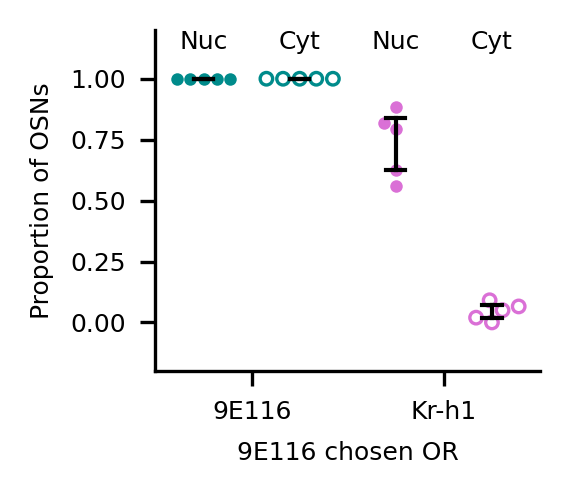

In [37]:
plot_nuc_cyto_props(input, results_melted, "9E116 chosen OR", ["9E116", "Kr-h1"], ['darkcyan', 'orchid'], figwidth=2, figheight=1.75)

# FIGURE 4

## U34, U21, PR

In [38]:
input = 'U21'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI as input directory


In [39]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

<Axes: xlabel='nuc_norm_log', ylabel='Count'>

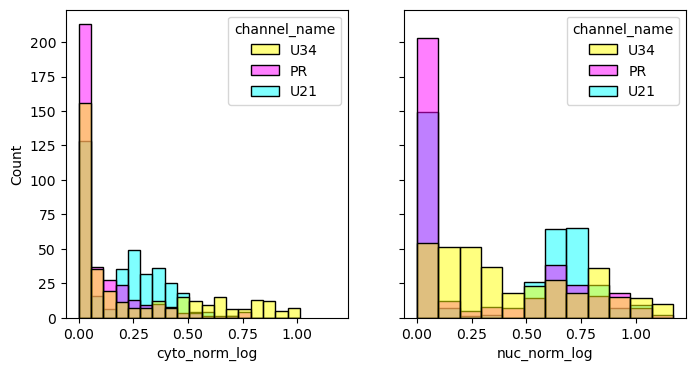

In [40]:
# Plot density of log-intensities for different channels 
results_melted['cyto_norm_log'] = np.log1p(results_melted['cyto-norm'])
results_melted['nuc_norm_log'] = np.log1p(results_melted['nuc-norm'])
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.histplot(data=results_melted, x='cyto_norm_log', hue='channel_name', fill=True, common_norm=False, palette=channel_colors, alpha=0.5, ax=ax[0])
sns.histplot(data=results_melted, x='nuc_norm_log', hue='channel_name', fill=True, common_norm=False, palette=channel_colors, alpha=0.5, ax=ax[1])

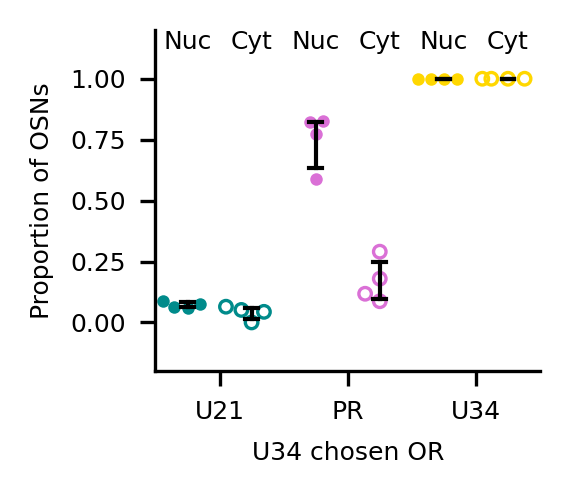

In [41]:
plot_nuc_cyto_props(input, results_melted, "U34 chosen OR", ["U21", "PR", "U34"], ['darkcyan', 'orchid', 'gold'], figwidth=2, figheight=1.75)

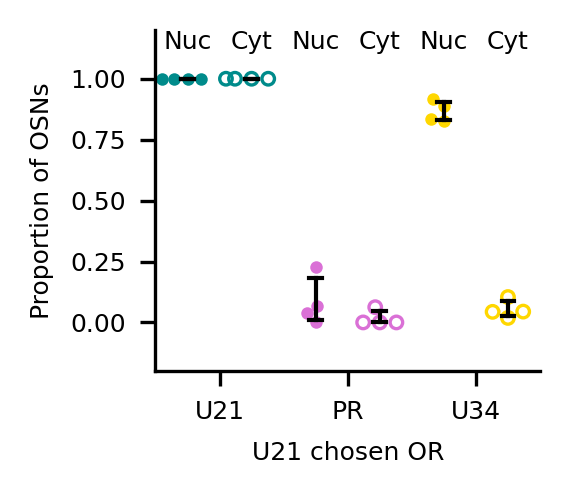

In [42]:
plot_nuc_cyto_props(input, results_melted, "U21 chosen OR", ["U21", "PR", "U34"], ['darkcyan', 'orchid', 'gold'], figwidth=2, figheight=1.75)

## G1 & lncRNA

In [43]:
input = 'G1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI as input directory


In [44]:
channels = ['AF546', 'AF647']
channel_names = ["G1", "LOC113562161"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [45]:
# Pearson correlation of AF546-nuc-norm and AF647-nuc-norm
from scipy.stats import pearsonr
r, p = pearsonr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Pearson correlation coefficient: {r}, p-value: {p}")

Pearson correlation coefficient: 0.8691515420217641, p-value: 0.0


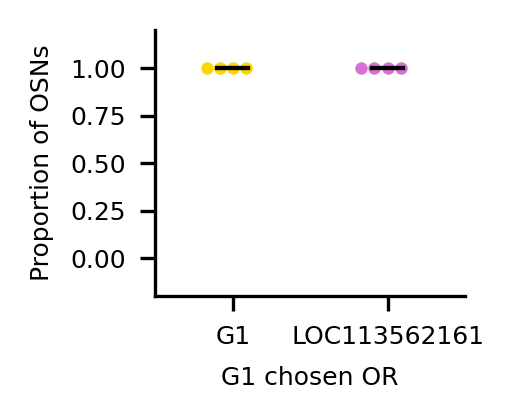

In [46]:
plot_nuc_props(input, results_melted, "G1 chosen OR", ["G1", "LOC113562161"], ['gold', 'orchid'], figwidth=1.75, figheight=1.5)

## 9E88 & lncRNA

In [47]:
input = '20250523 B'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

# Load melted results 
results_melted_path = os.path.join(results_dir, 'all_results_melted.csv')
results_melted = pd.read_csv(results_melted_path)

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250523 B P14 T 9E88-546 Lnc-647 DAPI as input directory


In [48]:
channels = ['AF546', 'AF647']
channel_names = ["9E88", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

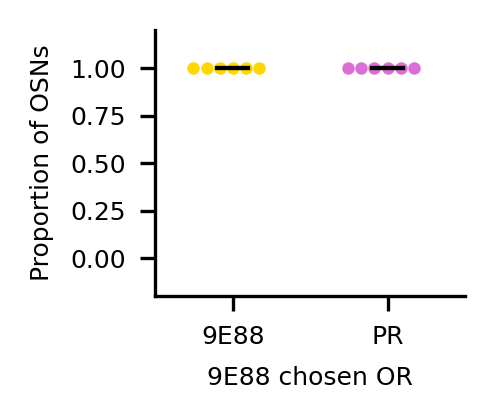

In [49]:
plot_nuc_props(input, results_melted, "9E88 chosen OR", ["9E88", "PR"], ['gold', 'orchid'],  figwidth=1.75, figheight=1.5)

# Supplementary 4

## Q1, R2, PR

In [50]:
input = 'Q1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI as input directory


In [51]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["R2/3", "Q1", "PR"]
channel_colors = ["cyan", "yellow", "magenta"]
channel_maxs = [255, 255, 255]

<Axes: xlabel='nuc_norm_log', ylabel='Count'>

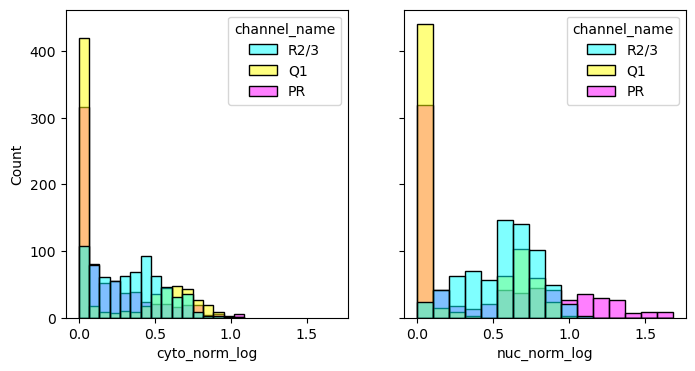

In [52]:
# Plot density of log-intensities for different channels 
results_melted['cyto_norm_log'] = np.log1p(results_melted['cyto-norm'])
results_melted['nuc_norm_log'] = np.log1p(results_melted['nuc-norm'])
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.histplot(data=results_melted, x='cyto_norm_log', hue='channel_name', fill=True, common_norm=False, palette=channel_colors, alpha=0.5, ax=ax[0])
sns.histplot(data=results_melted, x='nuc_norm_log', hue='channel_name', fill=True, common_norm=False, palette=channel_colors, alpha=0.5, ax=ax[1])

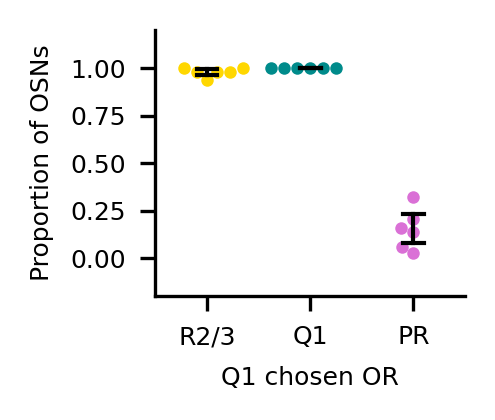

In [53]:
plot_nuc_props(input, results_melted, "Q1 chosen OR", ["R2/3", "Q1", "PR"], ['gold', 'darkcyan', 'orchid'], figwidth=1.75, figheight=1.5)

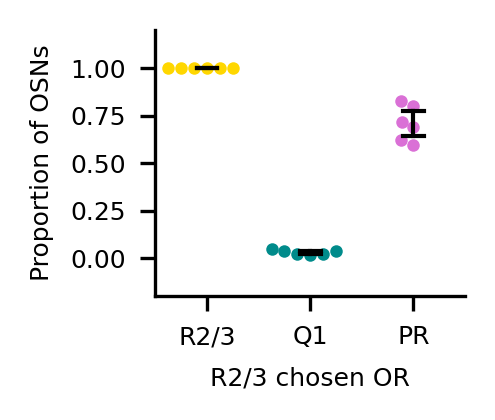

In [54]:
plot_nuc_props(input, results_melted, "R2/3 chosen OR", ["R2/3", "Q1", "PR"], ['gold', 'darkcyan', 'orchid'], figwidth=1.75, figheight=1.5)

## L16 & PR

In [55]:
input = 'L16'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI as input directory


In [56]:
channels = ['AF594', 'AF647']
channel_names = ["L16", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

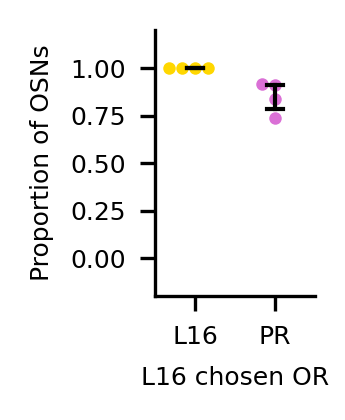

In [57]:
plot_nuc_props(input, results_melted, "L16 chosen OR", ["L16", "PR"], ['gold', 'orchid'], figwidth=1.25, figheight=1.5)

## U54 & PR

In [58]:
input = '20250523 C'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250523 C P14 T U54-647 Lnc4-546 DAPI as input directory


In [59]:
channels = ['AF647', 'AF546']
channel_names = ["U54", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

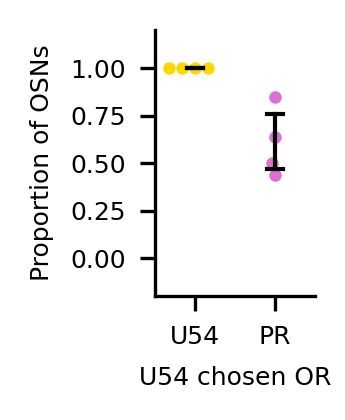

In [60]:
plot_nuc_props(input, results_melted, "U54 chosen OR", ["U54", "PR"], ['gold', 'orchid'], figwidth=1.25, figheight=1.5)

# FIGURE 7

## 9E89 & 9E99

In [61]:
input = '9E89-b1-546 9E99-B2-647'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI as input directory


In [62]:
results_melted.groupby(['image'])['chosen_OR_name'].value_counts().reset_index()

,image,chosen_OR_name,count
0,20250508 9e89 9e99 sample 1.czi,9E99 chosen OR,100
1,20250508 9e89 9e99 sample 1.czi,9E89 chosen OR,74
2,20250508 9e89 9e99 sample 2.czi,9E99 chosen OR,76
3,20250508 9e89 9e99 sample 2.czi,9E89 chosen OR,72
4,20250508 9e89 9e99 sample 4.czi,9E89 chosen OR,92
5,20250508 9e89 9e99 sample 4.czi,9E99 chosen OR,82
6,20250508 9e89 9e99 sample 5.czi,9E89 chosen OR,92
7,20250508 9e89 9e99 sample 5.czi,9E99 chosen OR,80
8,20250508 9e89 9e99 sample 6.czi,9E89 chosen OR,84
9,20250508 9e89 9e99 sample 6.czi,9E99 chosen OR,82


In [63]:
channels = ['AF546', 'AF647']
channel_names = ["9E89", "9E99"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

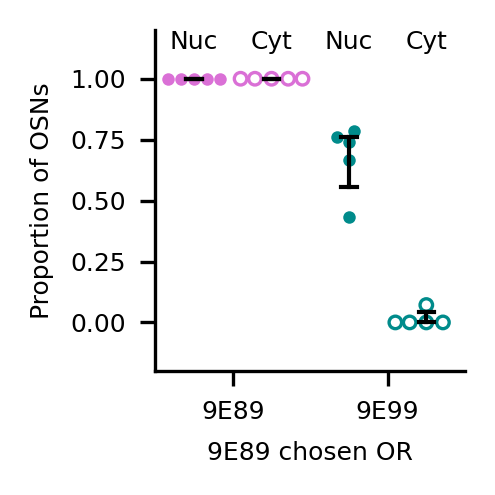

In [64]:
plot_nuc_cyto_props(input, results_melted, "9E89 chosen OR", ["9E89", "9E99"], ['orchid', 'darkcyan'], figwidth=1.75, figheight=1.75)

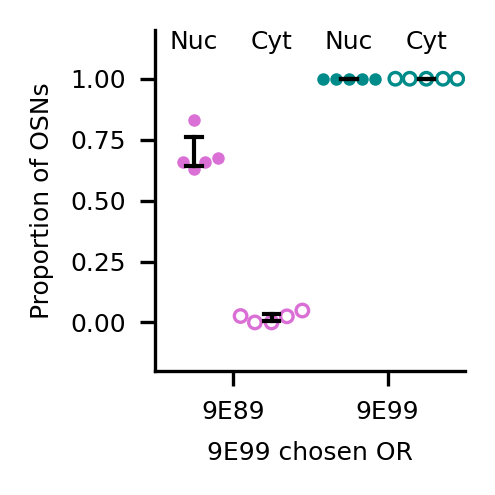

In [65]:
plot_nuc_cyto_props(input, results_melted, "9E99 chosen OR", ["9E89", "9E99"], ['orchid', 'darkcyan'], figwidth=1.75, figheight=1.75)

# Supplementary 7

## 9E196, 9E197, 9E198

In [66]:
input = '9E198'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI as input directory


In [67]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E198", "9E197", "9E196"]
channel_colors = ["magenta", "cyan", "yellow"]
channel_maxs = [255, 255, 255]

<Axes: xlabel='nuc_norm_log', ylabel='Count'>

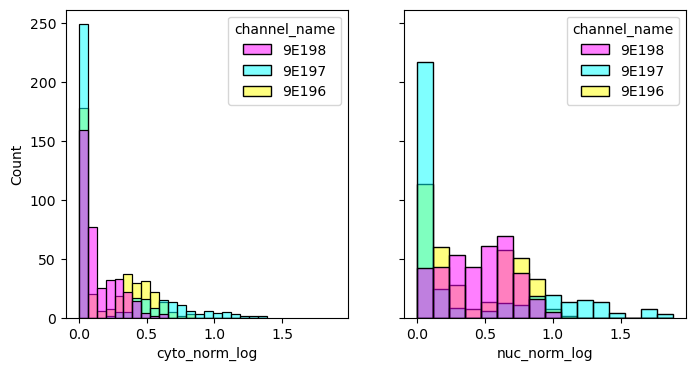

In [68]:
# Plot density of log-intensities for different channels 
results_melted['cyto_norm_log'] = np.log1p(results_melted['cyto-norm'])
results_melted['nuc_norm_log'] = np.log1p(results_melted['nuc-norm'])
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.histplot(data=results_melted, x='cyto_norm_log', hue='channel_name', fill=True, common_norm=False, palette=channel_colors, alpha=0.5, ax=ax[0])
sns.histplot(data=results_melted, x='nuc_norm_log', hue='channel_name', fill=True, common_norm=False, palette=channel_colors, alpha=0.5, ax=ax[1])

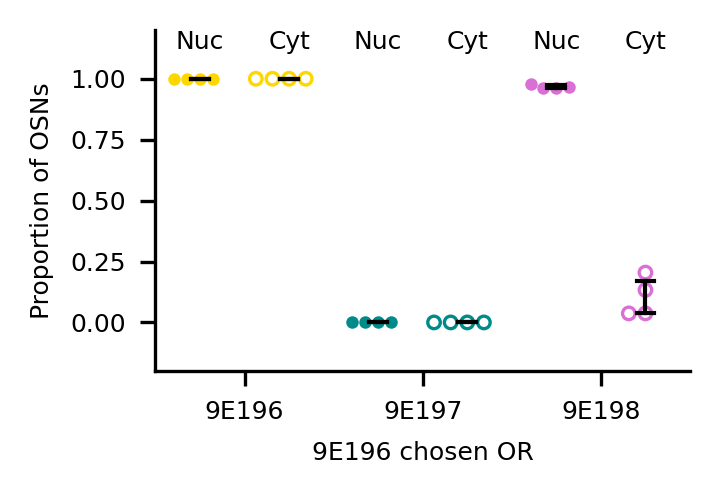

In [69]:
plot_nuc_cyto_props(input, results_melted, "9E196 chosen OR", ["9E196", "9E197", "9E198"], ['gold', 'darkcyan', 'orchid'], figwidth=2.5, figheight=1.75)

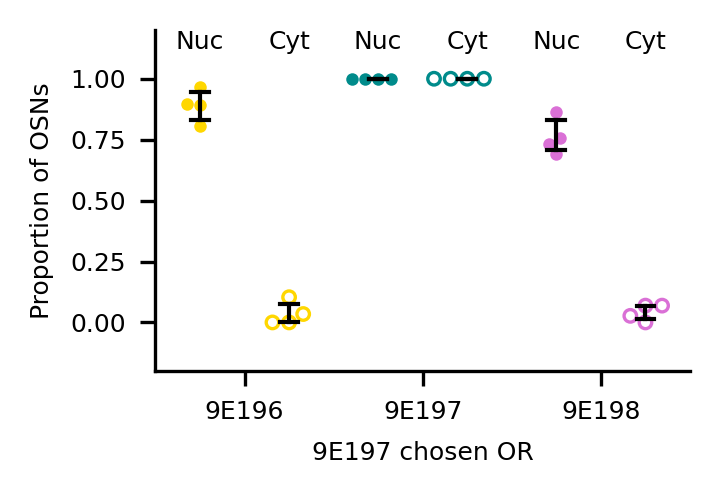

In [70]:
plot_nuc_cyto_props(input, results_melted, "9E197 chosen OR", ["9E196", "9E197", "9E198"], ['gold', 'darkcyan', 'orchid'], figwidth=2.5, figheight=1.75)

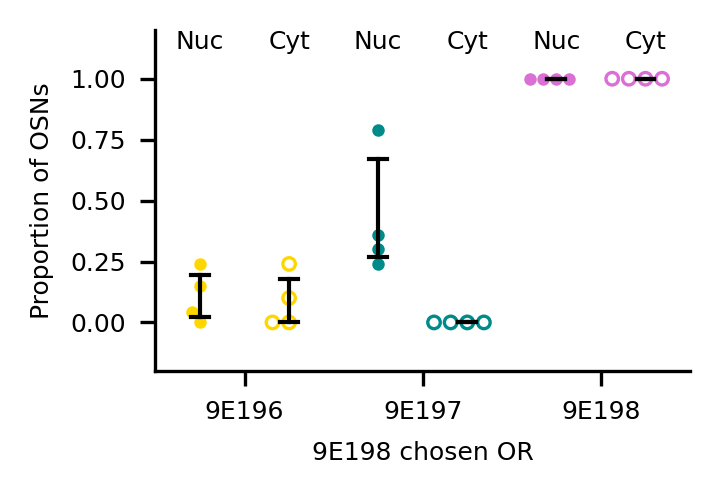

In [71]:
plot_nuc_cyto_props(input, results_melted, "9E198 chosen OR", ["9E196", "9E197", "9E198"], ['gold', 'darkcyan', 'orchid'], figwidth=2.5, figheight=1.75)

## Aggregate Final Stats

In [72]:
final_results_each_image_concated = pd.concat(final_results_each_image, axis=0)
final_results_concated = pd.concat(final_results, axis=0)

In [73]:
# Round the any float values to 2 decimal places
final_results_concated = final_results_concated.round(2)

In [74]:
# Pandas display 100 rows
pd.set_option('display.max_rows', 100)
final_results_concated

,chosen_OR_name,channel_name,image,channel,total_cells,nuclear,cytoplasmic,prop-nuclear,prop-cytoplasmic
0,U34 chosen OR,Chymotrypsin,5,AF647,54.40,51.20,7.20,0.95,0.16
1,U34 chosen OR,U34,5,AF546,54.40,54.40,54.40,1.00,1.00
0,U34 chosen OR,Orco,6,AF647,27.50,26.83,25.17,0.97,0.90
1,U34 chosen OR,U34,6,AF546,27.50,27.50,27.50,1.00,1.00
0,9E116 chosen OR,9E116,6,AF647,54.83,54.83,54.83,1.00,1.00
1,9E116 chosen OR,LOC105282603,6,AF488,54.83,47.67,3.00,0.87,0.06
0,9E99 chosen OR,9E99,4,AF594,36.00,36.00,36.00,1.00,1.00
1,9E99 chosen OR,LOC105286072,4,AF647,36.00,36.00,18.25,1.00,0.52
0,9E213 chosen OR,9E213,7,AF546,68.43,68.43,68.43,1.00,1.00
1,9E213 chosen OR,9E214,7,AF488,68.43,66.71,7.86,0.98,0.12


<Axes: xlabel='nucleus_eccentricity', ylabel='Density'>

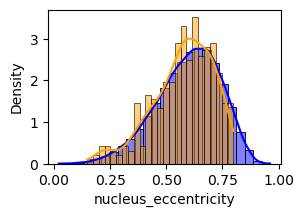

In [75]:
# plot Histogram of eccentricity values from results
f, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
sns.histplot(results['nucleus_eccentricity'], bins=25, kde=True, stat='density', ax=ax, color='blue', alpha=0.5)
sns.histplot(results_melted['nucleus_eccentricity'], bins=25, kde=True, stat='density', ax=ax, color='orange', alpha=0.5)

<Axes: xlabel='nucleus_area', ylabel='Density'>

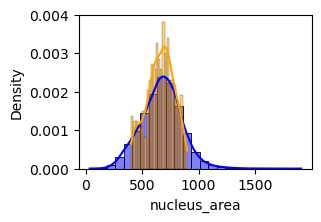

In [76]:
# plot Histogram of eccentricity values from results
f, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
sns.histplot(results['nucleus_area'], bins=25, kde=True, stat='density', ax=ax, color='blue', alpha=0.5)
sns.histplot(results_melted['nucleus_area'], bins=25, kde=True, stat='density', ax=ax, color='orange', alpha=0.5)

<Axes: xlabel='border_pxls', ylabel='Density'>

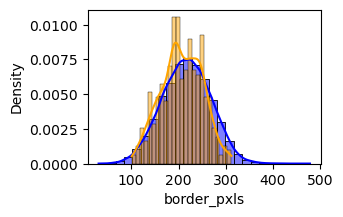

In [77]:
# plot Histogram of eccentricity values from results
f, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
sns.histplot(results['border_pxls'], bins=25, kde=True, stat='density', ax=ax, color='blue', alpha=0.5)
sns.histplot(results_melted['border_pxls'], bins=25, kde=True, stat='density', ax=ax, color='orange', alpha=0.5)